# mixed coordinate cutting plane examples

## arbitrary grid data examples

### full spherical domain

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import yt 
import unyt
from yt.geometry.coordinates.spherical_coordinates import spherical_to_cartesian

bbox = np.array([[0., 1.0], 
                [0, np.pi], 
                [0, 2*np.pi]])

def _get_slice_func(field_name):
    def _slicing_dim(field, data): 
        indx_fld = field_name.split('_')[-1]    
        d = data[('index', indx_fld)].d
        return unyt.unyt_array(d, "dimensionless")
    return _slicing_dim

def _z(field, data):
    r = data['index', 'r']
    theta = data['index', 'theta']
    phi = data['index', 'phi']
    _, _, z = spherical_to_cartesian(r, theta, phi)
    return unyt.unyt_array(z, r.units)

shp = (64, 64, 64)
data = {'density': np.random.random(shp)}

ds = yt.load_uniform_grid(data, 
                          shp, 
                          bbox=bbox, 
                          geometry='spherical', 
                          axis_order=('r', 'theta', 'phi'), 
                          length_unit='m', nprocs=1)

for fld in ('theta', 'phi', 'r'):
    ds.add_field(name=('stream', f"dim_{fld}"),
                 function=_get_slice_func(f"dim_{fld}"), 
                 sampling_type='cell', 
                 units='dimensionless', 
                 take_log=False)

ds.add_field(name=('index', "z_val"),
                 function=_z, 
                 sampling_type='cell',                  
                 take_log=False)



yt : [INFO     ] 2024-03-05 15:10:53,014 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-05 15:10:53,015 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-03-05 15:10:53,015 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-03-05 15:10:53,016 Parameters: domain_right_edge         = [1.         3.14159265 6.28318531]
yt : [INFO     ] 2024-03-05 15:10:53,016 Parameters: cosmological_simulation   = 0


create a standard slice in the x-z plane (at phi=0) for reference

yt : [INFO     ] 2024-03-05 15:10:53,130 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-03-05 15:10:53,131 ylim = -1.000000 1.000000
yt : [INFO     ] 2024-03-05 15:10:53,131 Setting origin='native' for spherical geometry.
yt : [INFO     ] 2024-03-05 15:10:53,134 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-03-05 15:10:53,134 ylim = -1.000000 1.000000
yt : [INFO     ] 2024-03-05 15:10:53,138 Making a fixed resolution buffer of (('stream', 'dim_theta')) 800 by 800



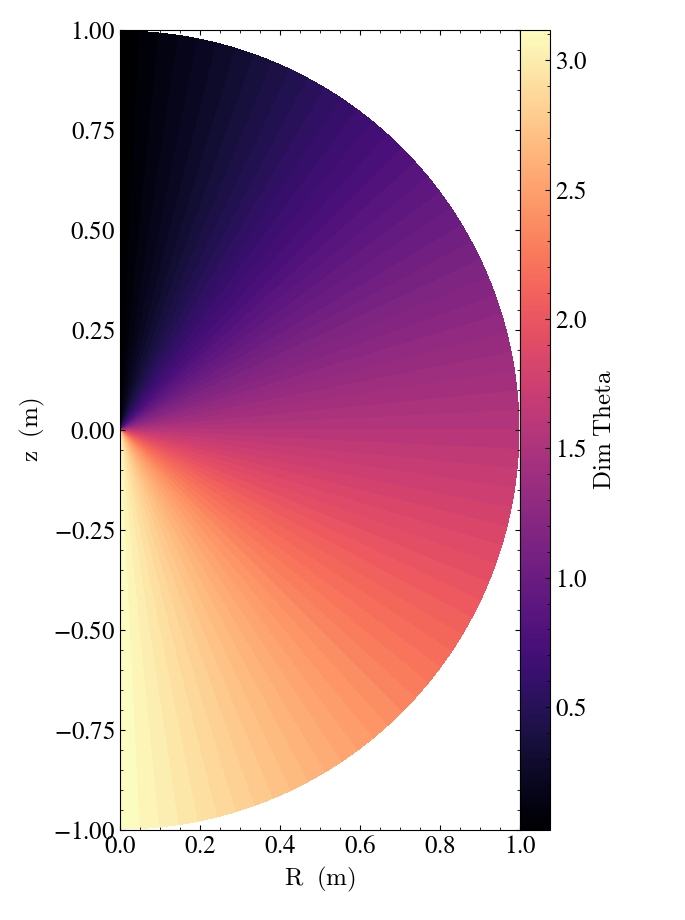

In [2]:
# slice in x-z plane
c = ds.domain_center.copy()
c[2] = 0.0
slc = yt.SlicePlot(ds, 'phi', 'dim_theta', center = c)
slc.set_cmap('dim_theta', 'magma')
slc.show()

Create a cutting plane in the x-z plane as well and extract a FRB with a width 
that covers the whole dataset domain

yt : [INFO     ] 2024-03-05 15:10:54,355 Making a fixed resolution buffer of (dim_theta) 400 by 400


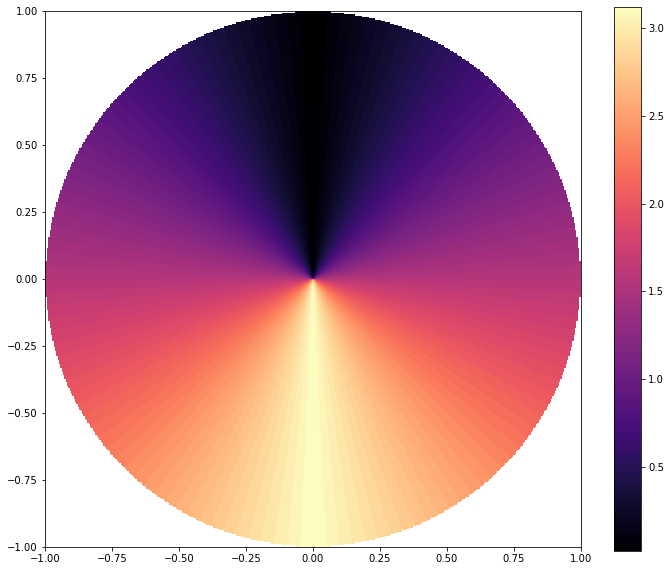

yt : [INFO     ] 2024-03-05 15:10:54,654 Making a fixed resolution buffer of (dim_r) 400 by 400


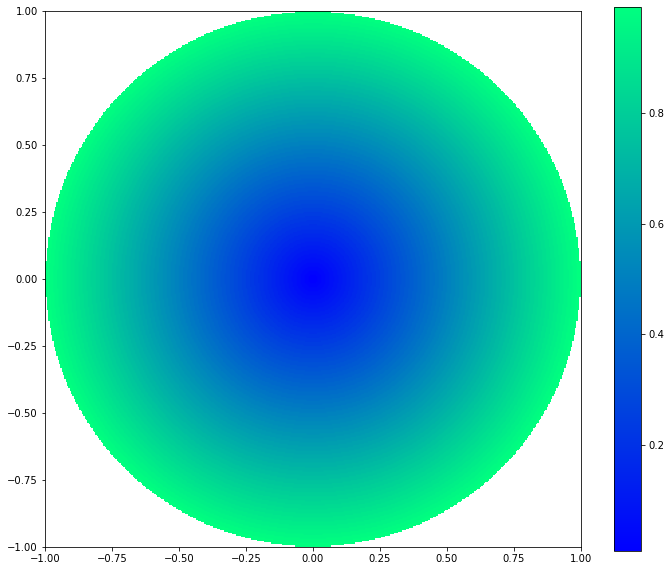

In [3]:
normal = np.array([0., 1., 0.])
center = np.array([0., 0., 0.])
north_vector = np.array([0., 0., 1.])

slc = ds.cutting_mixed(normal, center, north_vector=north_vector)
frb = slc.to_frb(2.0, 400)
vals = frb['dim_theta']
vals[~frb.get_mask('dim_theta')] = np.nan
fig = plt.figure(figsize=(12,10))
plt.imshow(vals, extent=frb.bounds, origin='lower', cmap='magma')
plt.colorbar()
plt.show()

vals = frb['dim_r']
vals[~frb.get_mask('dim_r')] = np.nan
fig = plt.figure(figsize=(12,10))
plt.imshow(vals, extent=frb.bounds, origin='lower', cmap='winter')
plt.colorbar()
plt.show()

but we can create arbitrary planes now too! 

The following creates a series of slices: each slice is parallel to the x-z plane, with the center shifting across the y axis:

yt : [INFO     ] 2024-03-05 15:10:54,873 Making a fixed resolution buffer of (('index', 'z_val')) 400 by 400
yt : [WARNING  ] 2024-03-05 15:10:54,886 Field ('index', 'z_val') was added without specifying units or dimensions, auto setting units to 'cm'


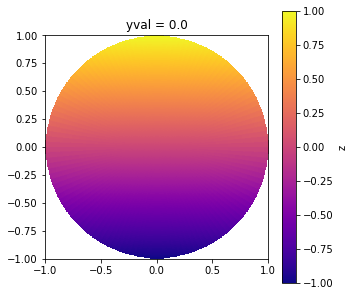

yt : [INFO     ] 2024-03-05 15:10:55,046 Making a fixed resolution buffer of (('index', 'z_val')) 400 by 400


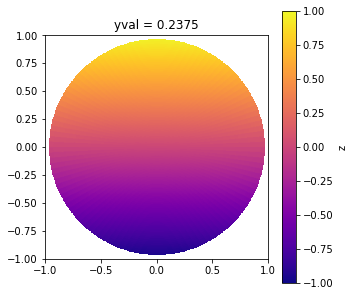

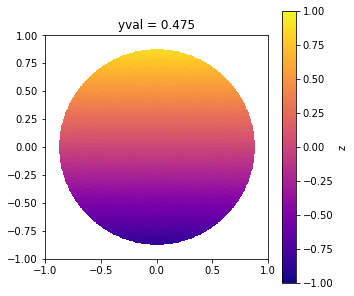

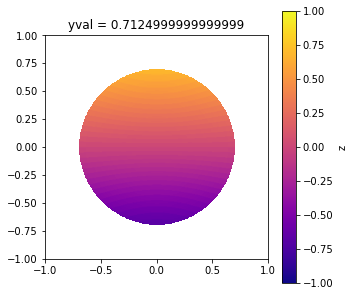

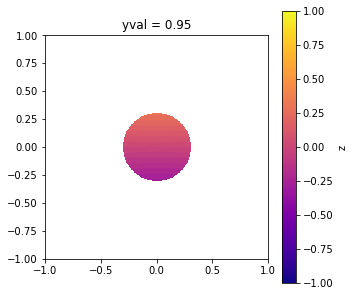

In [4]:
normal = np.array([0., 1., 0.])

yvals = np.linspace(0, 0.95, 5)
for yval in yvals:
    center = np.array([0.0, yval, 0.0])
    slc = ds.cutting_mixed(normal, center)
    frb = slc.to_frb(2.0, 400)
    
    vals = frb['index', 'z_val']
    vals[~frb.get_mask(('index', 'z_val'))] = np.nan
    
    fig = plt.figure(figsize=(5,5))
    plt.imshow(vals.to('code_length'), 
               extent=frb.bounds, 
               origin='lower', 
               cmap='plasma',
               clim=(-1,1),
              )
    plt.title(f"yval = {yval}")
    c = plt.colorbar()
    c.set_label('z')
    plt.show()

### cross sections

We can create a cross section by first creating a region that we'll then slice:

In [5]:
left_edge = ds.arr([0.5, 30*np.pi/180, 20*np.pi/180], 'code_length')
right_edge = ds.arr([0.9, 60*np.pi/180, 40*np.pi/180], 'code_length')
c = (left_edge + right_edge) / 2.0

region = ds.region(c, left_edge, right_edge)

now, define a start and end point. We'll construct a plane by taking the vectors defined by distance between the origin and each point and calculating a normal. In this case, we'll fix `phi` and `r` and vary `theta` only:

In [6]:
pt1 = np.array([0.9, left_edge[1].d, c[2].d])
pt2 = np.array([0.9, right_edge[1].d, c[2].d])

now, let's convert all our points to cartesian, calculate the normal vector and set the center point. Additionally, we'll provide a north vector pointing towards the center so that our cross-section image is oriented "up": 

In [7]:
pts = np.column_stack([pt1, pt2, c.d])
x, y, z = spherical_to_cartesian(pts[0,:], pts[1,:], pts[2,:])

normal = -np.cross((x[0], y[0], z[0]), (x[1], y[1], z[1]) )
center = np.array([x[2], y[2], z[2]])
north_vector = center

now contstruct the plane and create an FRB

yt : [INFO     ] 2024-03-05 15:10:55,823 Making a fixed resolution buffer of (dim_theta) 400 by 400


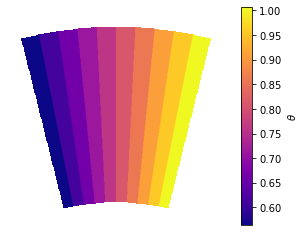

In [8]:
slc = ds.cutting_mixed(normal, center, north_vector=north_vector, data_source=region)
frb = slc.to_frb(0.5, 400)

vals = frb['dim_theta']
vals[~frb.get_mask('dim_theta')] = np.nan

fig, axs = plt.subplots(1)
im = axs.imshow(vals, 
           extent=frb.bounds, 
           origin='lower', 
           cmap='plasma',           
          )
axs.axes.axes.set_axis_off()
c = plt.colorbar(im)
c.set_label(r"$\theta$")
plt.show()

### slices through a limited domain

The slicing works just as well for datasets that do not span the full spherical domain

yt : [INFO     ] 2024-03-05 15:10:55,981 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-05 15:10:55,982 Parameters: domain_dimensions         = [20 20 20]
yt : [INFO     ] 2024-03-05 15:10:55,982 Parameters: domain_left_edge          = [0.5        0.52359878 0.34906585]
yt : [INFO     ] 2024-03-05 15:10:55,983 Parameters: domain_right_edge         = [1.         1.04719755 0.6981317 ]
yt : [INFO     ] 2024-03-05 15:10:55,983 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-05 15:10:56,126 Making a fixed resolution buffer of (dim_theta) 600 by 600


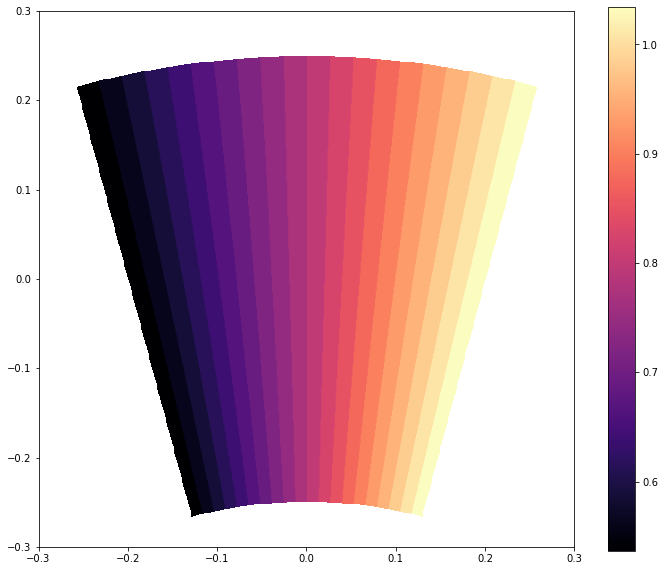

yt : [INFO     ] 2024-03-05 15:10:56,308 Making a fixed resolution buffer of (dim_r) 600 by 600


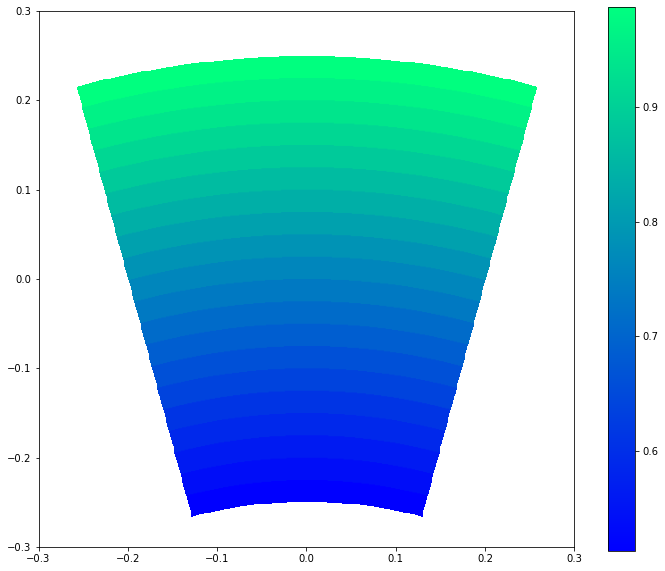

In [9]:
bbox = np.array([[0.5, 1.0], 
                [30, 60], 
                [20, 40]])
bbox[1:,:] = bbox[1:,:] * np.pi/180


shp = (20, 20, 20)
data = {'density': np.random.random(shp)}

ds = yt.load_uniform_grid(data, 
                          shp, 
                          bbox=bbox, 
                          geometry='spherical', 
                          axis_order=('r', 'theta', 'phi'), 
                          length_unit='m', nprocs=1)

for fld in ('theta', 'phi', 'r'):
    ds.add_field(name=('stream', f"dim_{fld}"),
                 function=_get_slice_func(f"dim_{fld}"), 
                 sampling_type='cell', 
                 units='dimensionless', 
                 take_log=False)

phi_val = ds.domain_center.d[2]
pt1 = np.array([1.0, ds.domain_left_edge[1].d, phi_val])
pt2 = np.array([1.0, ds.domain_right_edge[1].d, phi_val])
c = np.array([0.75, ds.domain_center[1].d, phi_val])

pts = np.column_stack([pt1, pt2, c])
x, y, z = spherical_to_cartesian(pts[0,:], pts[1,:], pts[2,:])
normal = -np.cross((x[0], y[0], z[0]), (x[1], y[1], z[1]) )
center = np.array([x[2], y[2], z[2]])
north_vector = center

slc = ds.cutting_mixed(normal, center, north_vector=north_vector)
frb = slc.to_frb(.6, 600)
vals = frb['dim_theta']
vals[~frb.get_mask('dim_theta')] = np.nan
fig = plt.figure(figsize=(12,10))
plt.imshow(vals, extent=frb.bounds, origin='lower', cmap='magma')
plt.colorbar()
plt.show()

vals = frb['dim_r']
vals[~frb.get_mask('dim_r')] = np.nan
fig = plt.figure(figsize=(12,10))
plt.imshow(vals, extent=frb.bounds, origin='lower', cmap='winter')
plt.colorbar()
plt.show()

### a note on "edge tolerance"

The way the fixed resolution buffer is constructed involves converting from the in-plane x-y coordinates to spherical coordinates. This introduces a bit of error, and when calculating whether a point on the image buffer falls within a spherical element, sometimes that small error causes that check to fail. 

To avoid this issue, a small tolerance factor, `edge_tol` is added within the pixelization routine. Depending on the size of a grid's elements and the resolution of the image buffer, this tolerance may need to be adjusted so it is exposed as a keyword argument to `ds.cutting_mixed`. 

We can demonstrate it's effect by setting the `edge_tol` to 0.0: 

yt : [INFO     ] 2024-03-05 15:10:56,488 Making a fixed resolution buffer of (dim_theta) 600 by 600


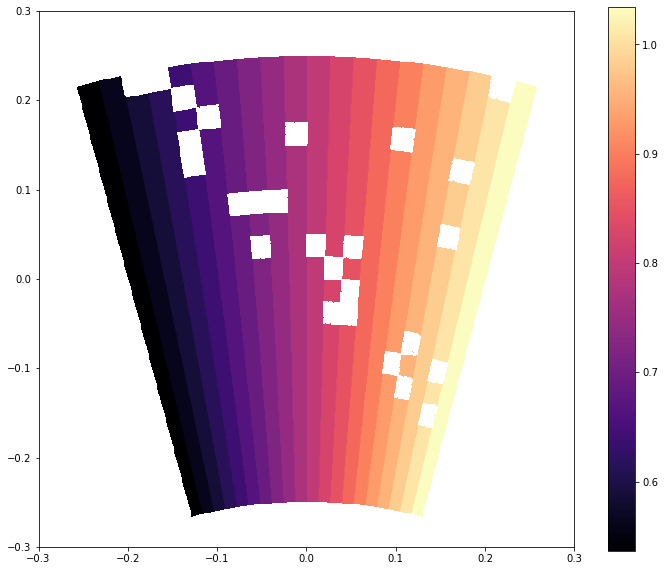

In [10]:
slc = ds.cutting_mixed(normal, 
                       center, 
                       north_vector=north_vector, 
                      edge_tol=0.0)
frb = slc.to_frb(.6, 600)
vals = frb['dim_theta']
vals[~frb.get_mask('dim_theta')] = np.nan

fig = plt.figure(figsize=(12,10))
plt.imshow(vals, extent=frb.bounds, origin='lower', cmap='magma')
plt.colorbar()
plt.show()

The blank pixels are spots where the rounding error cause a pixel to fail a bounds check for an element. Increasing the edge tolerance will fill in those pixels (the default is 1e-12).

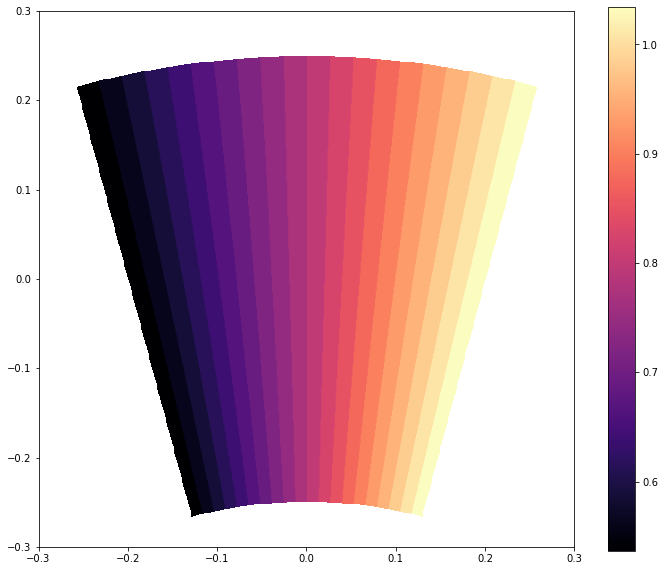

In [11]:
slc = ds.cutting_mixed(normal, 
                       center, 
                       north_vector=north_vector, 
                      edge_tol=1e-8)
frb = slc.to_frb(.6, 600)
vals = frb['dim_theta']
vals[~frb.get_mask('dim_theta')] = np.nan

fig = plt.figure(figsize=(12,10))
plt.imshow(vals, extent=frb.bounds, origin='lower', cmap='magma')
plt.colorbar()
plt.show()

increasing it **too** much will start to blur adjacent elements and find values where there shouldn't be

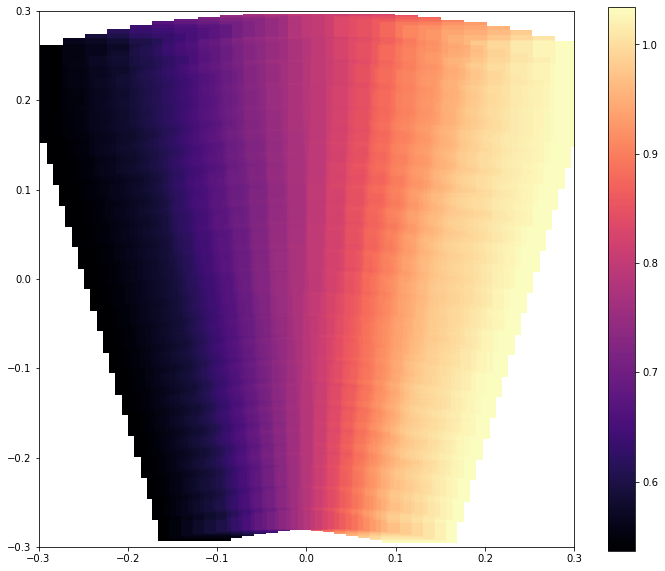

In [12]:
slc = ds.cutting_mixed(normal, 
                       center, 
                       north_vector=north_vector, 
                      edge_tol=1e-1)
frb = slc.to_frb(.6, 600)
vals = frb['dim_theta']
vals[~frb.get_mask('dim_theta')] = np.nan

fig = plt.figure(figsize=(12,10))
plt.imshow(vals, extent=frb.bounds, origin='lower', cmap='magma')
plt.colorbar()
plt.show()

## example with an actual (sample) dataset

using a 3d spherical, yt sample dataset (KeplerianDisk)

In [13]:
import yt
import numpy as np
import matplotlib.pyplot as plt 

# load a dataset in 3d spherical coordinates
ds = yt.load_sample("KeplerianDisk")

yt : [INFO     ] 2024-03-05 15:10:57,491 Sample dataset found in '/home/chavlin/hdd/data/yt_data/yt_sample_sets/KeplerianDisk/disk.out1.00000.athdf'
yt : [WARNING  ] 2024-03-05 15:10:57,565 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2024-03-05 15:10:57,565 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2024-03-05 15:10:57,566 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2024-03-05 15:10:57,566 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-03-05 15:10:57,623 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-05 15:10:57,624 Parameters: domain_dimensions         = [256  64   4]
yt : [INFO     ] 2024-03-05 15:10:57,624 Parameters: domain_left_edge          = [0.3        1.17809725 0.        ]
yt : [INFO     ] 2024-03-05 15:10:57,625 Parameters: domain_right_edge         = [3.         1.96349541 6.28318531]
yt : [INFO     ] 2024-03-05 15:10:57,625 Parameters: cosmological_simulation   = 0


for reference, a phi-normal slice at phi=0, normal to the x-z plane looks like

yt : [INFO     ] 2024-03-05 15:10:57,900 xlim = 0.277164 3.000000
yt : [INFO     ] 2024-03-05 15:10:57,901 ylim = -1.148050 1.148050
yt : [INFO     ] 2024-03-05 15:10:57,901 Setting origin='native' for spherical geometry.
yt : [INFO     ] 2024-03-05 15:10:57,903 xlim = 0.277164 3.000000
yt : [INFO     ] 2024-03-05 15:10:57,904 ylim = -1.148050 1.148050
yt : [INFO     ] 2024-03-05 15:10:57,905 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



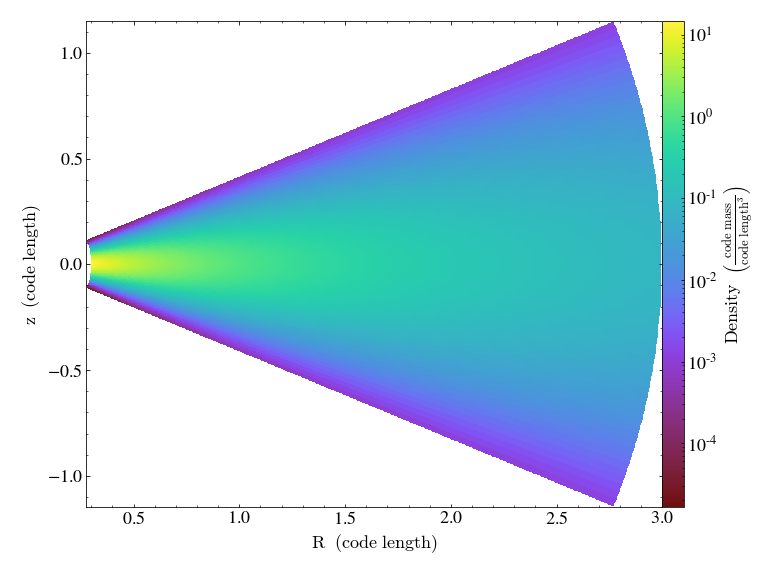

In [14]:
yt.SlicePlot(ds, 'phi', 'density', center=ds.arr([0.,0.,0.], 'code_length'))

now with the mixed-coord cutting plane, but spanning both phi = 0 and pi

yt : [INFO     ] 2024-03-05 15:10:58,752 Making a fixed resolution buffer of (('athena_pp', 'dens')) 800 by 800


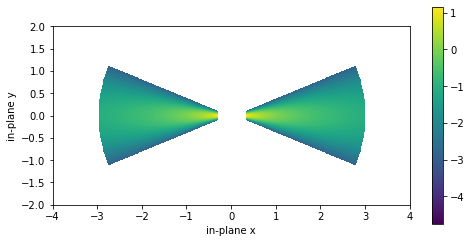

In [15]:

# define a cartesian plane (in cartesian coordinates)
# the following plane will be the x-z plane
normal = np.array([0.0, 1.0, 0.0])
plane_center = np.array([0.0, 0.0, 0.0])
slc = ds.cutting_mixed(normal, plane_center)

# extract a frb, width and height here are 
# in-plane cartesian distances measured from the 
# plane_center
frb = slc.to_frb(8.0, 800, height=4.0)
bvals = frb[("athena_pp", "dens")]

# mask out empty values for plotting
mask = frb.get_mask(("athena_pp", "dens"))
bvals[~mask] = np.nan

# plot it
f = plt.figure(figsize=(8,4))
plt.imshow(np.log10(bvals), extent=frb.bounds, origin='lower')
plt.xlabel("in-plane x")
plt.ylabel("in-plane y")
plt.colorbar()

and now a slice parallel to the x-y plane, centered at the origin

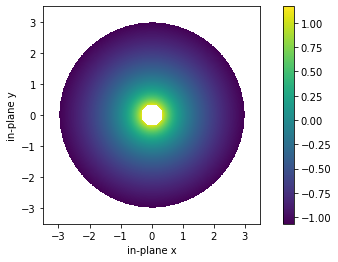

In [16]:
normal = np.array([0.0, 0.0, 1.0])
plane_center = np.array([0.0, 0.0, 0.0])
slc = ds.cutting_mixed(normal, plane_center)
frb = slc.to_frb(7.0, 800)

bvals = frb[("athena_pp", "dens")]
mask = frb.get_mask(("athena_pp", "dens"))
bvals[~mask] = np.nan

# plot it
f = plt.figure(figsize=(8,4))
plt.imshow(np.log10(bvals), extent=frb.bounds, origin='lower')
plt.xlabel("in-plane x")
plt.ylabel("in-plane y")
plt.colorbar()